# PCA: Principal Component Analysis

This notebook implements principal component analysis, an unsupervised learning method. Abbreviated as PCA, it is a dimensionality reduction method that is often used to reduce the dimensionality of large data sets.

---

First, load the relevant libraries needed.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Set the Seaborn theme
sns.set_theme()
from matplotlib.colors import ListedColormap

# Import helpful functions from scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix

## The Data

The model will be trained using the [Hawks](https://github.com/kary5678/INDE-577/blob/main/Data/hawks.csv) dataset. This dataset contains observations for three species of hawks, and attributes such as age, sex, wing length, body weight, tail length, etc. 

The code block below reads the dataset into a pandas DataFrame object, subsets the DataFrame to the relevant variables, and drops any rows where there are missing values for these relevant variables.

In [2]:
# Read in the data and subset it to the relevant columns/observations
hawks = pd.read_csv("../../Data/hawks.csv")
hawks = hawks[["Species", "Wing", "Tail", "Weight", "Culmen", "Hallux"]].dropna(axis=0)
hawks

,Species,Wing,Tail,Weight,Culmen,Hallux
0,RT,385.0,219,920.0,25.7,30.1
2,RT,381.0,235,990.0,26.7,31.3
3,CH,265.0,220,470.0,18.7,23.5
4,SS,205.0,157,170.0,12.5,14.3
5,RT,412.0,230,1090.0,28.5,32.2
...,...,...,...,...,...,...
903,RT,380.0,224,1525.0,26.0,27.6
904,SS,190.0,150,175.0,12.7,15.4
905,RT,360.0,211,790.0,21.9,27.6
906,RT,369.0,207,860.0,25.2,28.0


## Running PCA with scikit-learn

I will be first be using `PCA` from the scikit-learn library to understand how this algorithm works.

### Data preparation - using the full 5 feature predictor set

Because PCA is a dimensionality reduction method, it makes sense to just use the full 5 feature predictor set.

One caveat is that the data needs to be standardized, so that all features are on the same scale to better find the features that explain most of the variance.

In [3]:
X = hawks[["Wing", "Tail", "Weight", "Culmen", "Hallux"]]
y = hawks["Species"]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

One parameter that needs to be determined to run PCA is the number of components. I plot the total variance explained by the principal components for a range of `n_components`.

In [4]:
def plot_explained_variance(X):
    """
    A diagnostic plot to determine the optimal number of components for PCA by
    plotting the percentage of variance explained for each number of components.
    """
    possible_n = range(2, X_scaled.shape[1] + 1, 1)
    variances = []
    for k in possible_n:
        pca = PCA(n_components = 2)
        pca.fit(X)
        variances.append(sum(pca.explained_variance_ratio_) * 100)
    plt.figure(figsize = (7, 5))
    plt.plot(possible_n, variances, color = 'red', marker = "o")
    plt.xlabel("n_components", fontsize = 12)
    plt.ylabel("Explained variance (%)", fontsize = 12)
    plt.title("Percentage of variance explained by principal components", fontsize = 14)
    plt.xticks(possible_n)

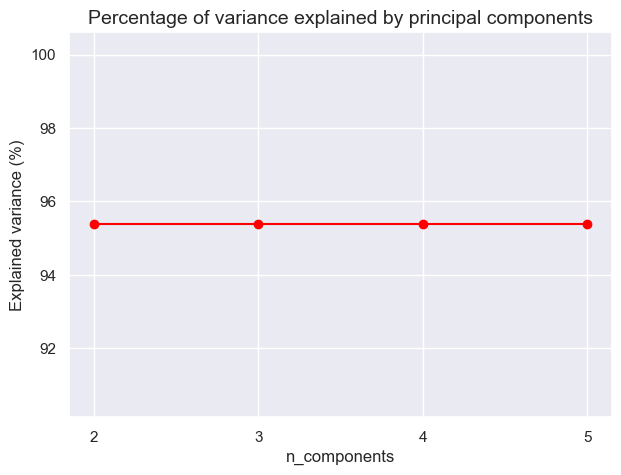

In [5]:
plot_explained_variance(X_scaled)

By the plot above, it makes sense to proceed with `n_components=2`.

In [6]:
# Create a PCA object with the desired number of components
pca = PCA(n_components=2)

# Fit the PCA object to the scaled data
pca.fit(X_scaled)

# Print the explained variance ratio of each principal component, and in total
print(pca.explained_variance_ratio_)
print("Total variance explained:", sum(pca.explained_variance_ratio_))

[0.80269141 0.15100066]
Total variance explained: 0.9536920756793945


80% of the variance is explained by the first principal component, while an additional 15% is explained by the second principal component, as one can see from the scree plot below.

In [7]:
def scree_plot(pca):
    """
    Plot the percentage of variation explained by each principal component
    """
    n = pca.n_components_
    labels = [f"PC{i}" for i in range(1, n+1)]

    plt.figure(figsize = (7, 5))
    plt.bar(x = range(1, n+1), height = pca.explained_variance_ratio_ * 100, tick_label = labels)
    plt.xlabel('Principal component', fontsize = 12)
    plt.ylabel('Percentage of variation', fontsize = 12)
    plt.title('Scree Plot', fontsize = 14)

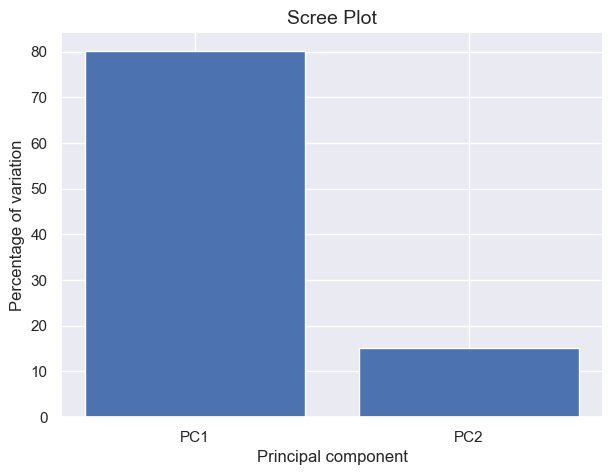

In [8]:
scree_plot(pca)

By using the weights below, the original 5D dataset is able to be reduced down to a 2D feature set.

In [9]:
pca.components_

array([[ 0.4842003 ,  0.46992847,  0.48030932,  0.48868016,  0.274248  ],
       [-0.13690084, -0.14333054, -0.13545933, -0.13303371,  0.96159623]])

Each row of the components_ matrix corresponds to a principal component, and the columns correspond to the original features in the dataset. The values in each row indicate the weight or importance of each feature in that component.

In other words, the larger the absolute value of a weight in a principal component, the more that feature contributes to that component. Higher values in pca.components_ can indicate more important variables, but it's important to note that the sign of the weight matters as well. Furthermore, the weights in pca.components_ are normalized, so they represent the direction of maximum variance in the data rather than the absolute importance of each feature.

In [10]:
# Transform the data to its principal components
X_transformed = pca.transform(X_scaled)
X_transformed.shape

(891, 2)

From the 5D feature set, we are now at a 2D feature set.

What does this look like with respect to the species in the data?

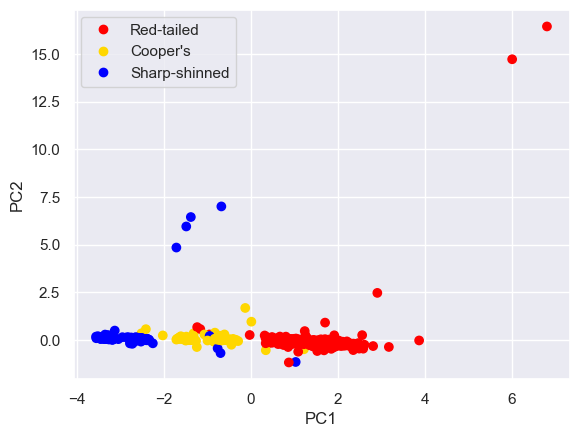

In [11]:
# Create a scatter plot using the first two principal components

# Customize colors for each species
species_colors = {"RT": 0, "CH": 1, "SS": 2}
colors = ["red", "gold", "blue"]
cmap = ListedColormap(colors)

scatter = plt.scatter(X_transformed[:,0], X_transformed[:,1], c = [species_colors[hawk] for hawk in y], cmap = cmap)
plt.legend(handles = scatter.legend_elements()[0], labels=["Red-tailed", "Cooper's", "Sharp-shinned"])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

By the plot above, PCA collapses the data in a way that the species clusters are still prominent. There are still hawks that deviate from the main clusters, specifically red-tailed and sharp-shinned, but there were deviations in the original data anyways. See the [hawks analysis notebook](https://github.com/kary5678/INDE-577/blob/main/Data/hawks_analysis.ipynb) for a refresher on the distribution of the original data.

Note that PCA is an unsupervised learning method, meaning that labels are typically not available. Having them is helpful in understanding the benefits of PCA!

## Application: kNN with vs. without PCA

By reducing the number of features by transforming the data into a lower-dimensional space that captures the most important patterns in the data, PCA can potentially make model training more computationally efficient by reducing the dimensionality of the data. In this section, I will run *k*-nearest neighbors (kNN) using the full 5 feature set as I did in my [kNN notebook](https://github.com/kary5678/INDE-577/blob/main/supervised-learning/knn/knn.ipynb), followed by the reduced PCA feature set, noting any differences.

In [12]:
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings('ignore') # surpress deprecation warnings

### Without PCA (full 5 features)

I use `n_neighbors=5` because that is what I used in my kNN notebook for this feature set.

In [13]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X, y)
knn.score(X, y)

0.9831649831649831

In [14]:
y_pred = knn.predict(X)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

          CH       0.92      0.87      0.90        69
          RT       0.99      1.00      0.99       567
          SS       0.98      0.98      0.98       255

    accuracy                           0.98       891
   macro avg       0.96      0.95      0.96       891
weighted avg       0.98      0.98      0.98       891



kNN with all 5 features does well to classify the data to start with. Let's look more closely into the misclassifications with the confusion matrix:

In [15]:
def plot_hawk_confusion_matrix(y_actual, y_pred):
    """
    Plots the confusion matrix given the actual and predicted values
    to easily view accurate classifications and type I/II errors
    """             
    # Obtain confusion matrix
    classes = ["RT", "CH", "SS"]
    cf_matrix = confusion_matrix(y_actual, y_pred, labels = classes)

    # View the confusion matrix using the seaborn package
    plt.figure(figsize = (6, 4))
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')
    ax.set_title('Hawk Species Confusion Matrix', fontsize = 14)
    ax.set_xlabel("Predicted Label", fontsize = 12)
    ax.set_xticklabels(classes)
    ax.set_ylabel("True Label", fontsize = 12)
    ax.set_yticklabels(classes, rotation = 0)

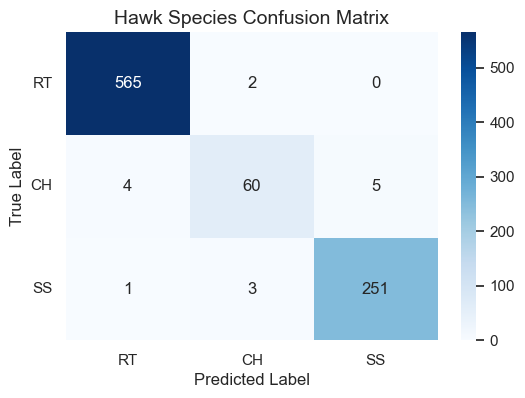

In [16]:
plot_hawk_confusion_matrix(y, y_pred)

Most of the hawks are accurately classified without a problem!

### With PCA (2 principal components)

Now, let's run kNN again after reducing redundant information and data dimensionality. I will use `n_neighbors=5` still for consistency.

In [17]:
knn_pca = KNeighborsClassifier(n_neighbors = 5)
knn_pca.fit(X_transformed, y)
knn_pca.score(X_transformed, y)

0.9854096520763187

In [18]:
y_pred2 = knn_pca.predict(X_transformed)
print(classification_report(y, y_pred2))

              precision    recall  f1-score   support

          CH       0.93      0.93      0.93        69
          RT       0.99      0.99      0.99       567
          SS       0.98      0.98      0.98       255

    accuracy                           0.99       891
   macro avg       0.97      0.97      0.97       891
weighted avg       0.99      0.99      0.99       891



Based on the metrics overall, kNN following PCA on the full 5 feature set performs better. Specifically, precision and recall for the Cooper's hawk (CH) have increased following transformation of the predictors using PCA.

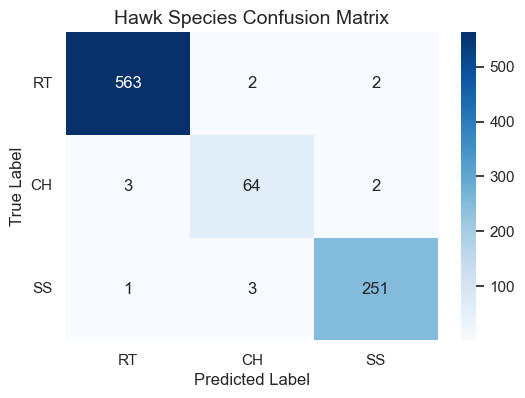

In [19]:
plot_hawk_confusion_matrix(y, y_pred2)

The confusion matrix confirms that precision and recall for the Cooper's hawk (CH) have increased following transformation of the predictors using PCA. Considering how this is the species with the least observations, clearly the performance of kNN has improved by using the first two principal components rather than the 5 predictors. Furthermore, as there are only two dimensions following PCA, having better accuracy while also being a less complex model makes this model a clear winner over the one that involves 5 dimensions.

## Concluding Remarks

In this notebook, I combined PCA, an unsupervised learning method, to improve the performance of supervised learning method kNN. In both versions of kNN, the full 5 predictor feature set was used, but PCA reduced the data down to two dimensions, or two principal components. Not only did performance increase slightly, but more importantly, complexity was reduced by a lot. The benefits of PCA are clear, and it is also a good way to understand the importance of each feature in the data! While the hawks data only has 5 predictor columns, on data with 10+ columns, PCA becomes an even more useful tool to understand the data and reduce dimensionality/complexity.